# Improvement of accuracy vs training frequency

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette, get_models_dir, get_negative_data, combine_positive_negative_data
from nlinec.data.preprocessing import get_granularity

## Parameters

In [3]:
granularities = ['Coarse', 'Medium', 'Fine']

In [4]:
models = os.listdir(get_models_dir())
print(models)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3']


In [5]:
# Specify the dataset to predict and a file to load the predictions from
SPLIT = "test"
DATASET = f'g_{SPLIT}.json'
BASE_MODEL = "roberta-large-mnli"
FINETUNED_MODELS = [f"nlinec-D-{i}" for i in range(1, 4)]
HYPOTHESIS_ONLY = False

## Load Data

In [6]:
base_type_accuracy = pd.read_csv(os.path.join(get_results_dir(), BASE_MODEL, f"{SPLIT}_type_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"), index_col=0)
finetuned_type_accuracy_list = [pd.read_csv(os.path.join(get_results_dir(), model, f"{SPLIT}_type_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"), index_col=0) for model in FINETUNED_MODELS]

In [7]:
# Load the data
positive_data = get_positive_data("augmented_train.json", explode=True)
negative_data = get_negative_data("augmented_train.json", random_state=42)

Loading augmented_train.json: 793487it [00:12, 64674.14it/s] 


Loading negative data from /home/psaegert/Projects/nli-nec/src/nlinec/../../data/derived/negative_data/augmented_train.json_42.csv...


In [8]:
# Find the frequency of the types in the training dataset
# Reconstruct the training dataset for the D series

type_counts_list = []

for granularity in [1, 2, 3]:
    data = combine_positive_negative_data(positive_data, negative_data, frac=0.5, random_state=42)

    # Add the basic type
    data[f'type_{granularity}'] = data['full_type'].apply(lambda x: get_type(x, granularity))

    # Remove the rows with type None
    data = data[data[f'type_{granularity}'].notna()]

    # Remove duplicates
    data = data.drop_duplicates(subset=['mention_span', 'sentence', f'type_{granularity}'])

    # Sample the data
    data = data.sample(n=81408, random_state=42).reset_index(drop=True)

    # Get the full type up to the granularity
    data[f'full_type_reduced'] = data['full_type'].apply(lambda x: get_type(x, granularity, include_path=True))

    # Count the types
    type_counts_list.append(data[f'full_type_reduced'].value_counts())

In [9]:
# Add the train type frequency to the type accuracy dataframes
for i in [1, 2, 3]:
    # Merge the type counts with the type accuracy
    finetuned_type_accuracy_list[i - 1] = finetuned_type_accuracy_list[i - 1].merge(type_counts_list[i - 1].rename(f'train_frequency'), left_on='full_type', right_index=True)

## Plot the type accuracy vs. the frequency of the type in the training dataset

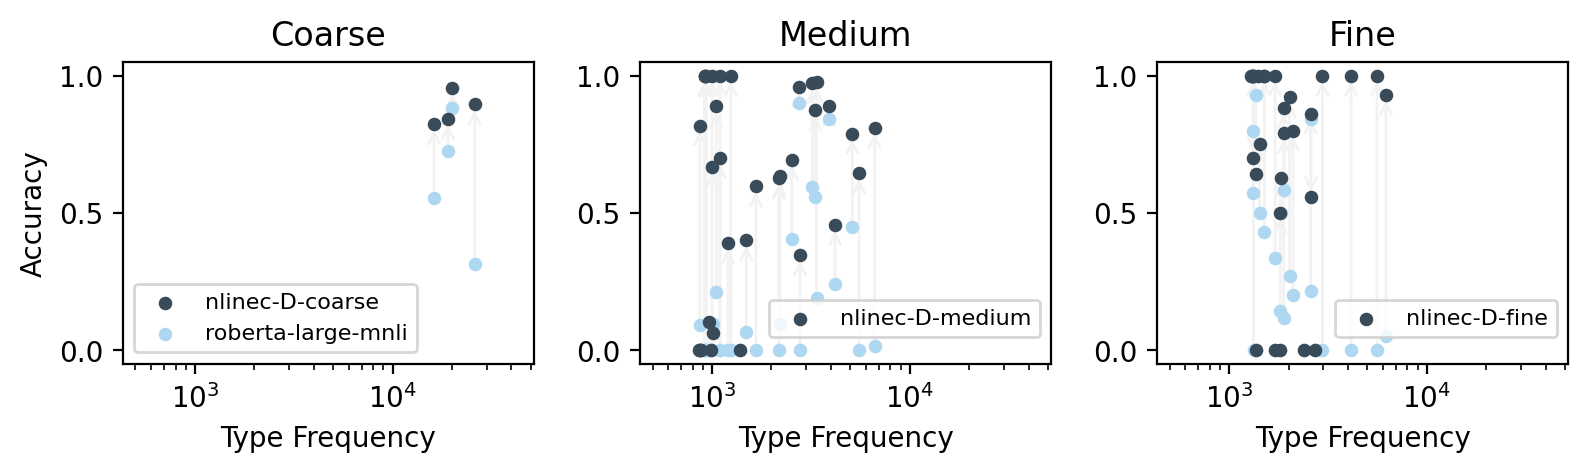

In [17]:
# Compare the accuracy of each type with the frequency of the type in the training set

fig, axes = plt.subplots(1, 3, figsize=(8, 2.1), dpi=200)
fig.tight_layout(w_pad=0.4)
xlim = (
    min([min(finetuned_type_accuracy_list[i]['train_frequency']) for i in range(3)]) / 2,
    max([max(finetuned_type_accuracy_list[0]['train_frequency']) for i in range(3)]) * 2
)

for i, ax, finetuned_type_accuracy, granularity in zip([1, 2, 3], axes, finetuned_type_accuracy_list, granularities):
    granularity_mask = base_type_accuracy['granularity'] == i
    ax.scatter(finetuned_type_accuracy.loc[granularity_mask, 'train_frequency'], finetuned_type_accuracy.loc[granularity_mask, 'accuracy'], color=color_palette('medium'), s=15, label=f'nlinec-D-{granularity.lower()}', zorder=4)
    ax.scatter(finetuned_type_accuracy.loc[granularity_mask, 'train_frequency'], base_type_accuracy.loc[granularity_mask, 'accuracy'], color=color_palette('light'), s=15, label='roberta-large-mnli' if i == 1 else None, zorder=3)

    # Draw faint arrows from the base accuracy to the finetuned accuracy
    for x, y1, y2 in zip(finetuned_type_accuracy.loc[granularity_mask, 'train_frequency'], base_type_accuracy.loc[granularity_mask, 'accuracy'], finetuned_type_accuracy.loc[granularity_mask, 'accuracy']):
        ax.annotate("", xy=(x, y2), xytext=(x, y1), arrowprops=dict(arrowstyle="->", color=color_palette('bright'), lw=1), zorder=1)

    ax.set_xscale('log')
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlim(xlim)
    ax.set_title(granularity)
    ax.set_xlabel('Type Frequency')

axes[0].legend(fontsize=8, loc='lower left')
axes[1].legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0.05))
axes[2].legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0.05))
axes[0].set_ylabel('Accuracy');

In [11]:
# ['#aed8f2', '#f2c8ae', '#d8f2ae'], ['#4c7599', '#99704c', '#75994c']